In [33]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch import nn
from sklearn.metrics import confusion_matrix, f1_score
import re
import torch
from torch.utils.data import TensorDataset, DataLoader


In [2]:
FILE_PATH = r"drama_202410242014.csv"

In [3]:
df= pd.read_csv(FILE_PATH)

In [6]:
# 카테고리를 라벨링하는 함수
def change_category(value):

    if 'nineteen' in value: #18세
        return 0 

    elif 'fifteen' in value: # 15세
        return 1

    elif 'twelve' in value: # 12세
        return 0
    
    elif 'seven' in value: # 7세
        return 0
    
    elif 'all' in value:  # 전체이용가
        return 0

    else:
        return value


In [8]:
# apply 함수를 사용해 각 행의 값을 change_category 함수로 처리
df['category'] = df['category'].apply(change_category)

In [41]:
df['category'].value_counts()

category
1    2209
0     281
Name: count, dtype: int64

In [10]:
def re_text(text):

    text = re.sub(r'[^\n가-힇\s]', '', text)  
    text = re.sub(r'\s+', ' ', text)
    return text.strip()  # 앞뒤 공백제거

In [11]:
df['common'] = df['common'].apply(re_text)

In [51]:
from googletrans import Translator
# Translator 객체 생성
translator = Translator()

def back_translate(text, src='ko', mid='en', dest='ko'):
    try:
        # 한국어에서 영어로 번역
        translated = translator.translate(text, src=src, dest=mid).text
        # 다시 영어에서 한국어로 번역
        back_translated = translator.translate(translated, src=mid, dest=dest).text
        return back_translated
    except Exception as e:
        print(f"Error during translation: {e}")
        return text

In [56]:
augmented_df=df[df['category']==0]

In [58]:
augmented_df=df[df['category']==0]

# 'common' 컬럼에 백번역 적용하여 데이터 증강
augmented_df['common'] = augmented_df['common'].apply(back_translate)

# 원본 데이터와 증강된 데이터 합치기 (행 추가)
df_augmented = pd.concat([df, augmented_df], ignore_index=True)

# 결과 확인
print(df_augmented.shape)  # 데이터프레임의 크기 확인 (증강 후 행이 늘어났는지 확인)
print(df_augmented.head())

Error during translation: timed out
(2771, 5)
   id                  name                   blank  \
0   1             방과 후 전쟁활동   2023드라마TVING시즌 1개해설자막   
1   2           빙우화 : 마약 전쟁    2022드라마kt alpha시즌 1개   
2   3  대리인간 [드라마 스테이지 2021]        2021드라마tvN시즌 10개   
3   4                  아따맘마  2002애니메이션얼리버드 픽쳐스시즌 5개   
4   5             트라이건 스탬피드      2023애니메이션코코믹스시즌 1개   

                                              common  category  
0  하늘을 뒤덮은 괴생명체의 공격에 맞서 입시 전쟁이 아닌 진짜 전쟁을 시작한 고 학생...         0  
1  년 전 마약 밀매 조직 케이의 손에 아버지를 잃은 우전펑은 아버지의 억울함을 풀고 ...         1  
2  의 신인 스토리텔러 지원사업 오펜 공모전에서 당선된 개 작품으로 구성되는 단막극 프로그램         1  
3  언제나 정겨운 엄마 아빠 아리 동동 사랑스러운 네 가족이 돌아왔다 어디에나 있을 법...         0  
4  모래폭풍이 불어오는 가혹한 땅 그 곳은 지구에서 멀리 떨어져 있고 다섯 개의 달이 ...         0  


C:\Users\gksmf\AppData\Local\Temp\ipykernel_19208\1875747132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_df['common'] = augmented_df['common'].apply(back_translate)


In [63]:
df_augmented['common'] = df_augmented['common'].apply(re_text)

In [92]:
# train, test 나누기
train = df_augmented.sample(frac=0.9, random_state=42) # 랜덤으로 90를 선택
test = df_augmented.drop(train.index)                  # 트레인을 삭제해서 비율을 train : test = 9: 1

print(train.head(5))
print('Training Data Size : ', len(train))
print("Testing Data Size : ", len(test))

        id                  name                   blank  \
1106  1107  아가사 크리스티 명탐정 포와로 시즌5  1993드라마JAYE Ent.시즌 13개   
1321  1322               나만의 불청객      2023해외시리즈중화TV시즌 1개   
2313  2314         거짓말에서 시작되는 사랑       2021드라마플레이그램시즌 1개   
2274  2275                 덫의 전쟁         2023드라마채널W시즌 1개   
1432  1433                  호부전기       2012드라마AsiaN시즌 1개   

                                                 common  category  
1106                      명탐정 포와로가 미궁에 빠진 사건들을 풀어가는 이야기         1  
1321  쑤차오는 새로 전학 온 린쯔루와 첫날부터 티격태격하고 린쯔루가 룸메이트가 되면서 갑...         1  
2313           거짓말과 관련된 사연이 있는 네 남녀가 만나 펼쳐지는 러브 코미디 드라마         1  
2274  아들을 빈사의 중태로 몰아넣은 사건의 범인과 이를 은폐하려는 국회의원에 대한 복수를...         1  
1432  제 초 연 한 위 조 진 등 개 나라가 패권을 다투는 전국시기 신릉군 위무기는 어질...         1  
Training Data Size :  2494
Testing Data Size :  277


In [93]:
# 데이터 토큰화 및 단어 사전 구축
from konlpy.tag import Okt
from collections import Counter

## 단어사전을 만드는 함수
def build_vocab(corpus, n_vocab, special_tokens): #n_vocab은 최대 사용할 단어개수
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab): # 가장 많이 등장한 순서대로 상위 n_vocab개의 단어 반환
        vocab.append(token)
    return vocab


In [94]:
## 불용어 리스트 불러오는 함수
STOP_PATH = 'kor_stopwords.txt'

def make_stopwords(STOP_PATH):
    with open(STOP_PATH, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines() # 문장단위로
    return set(stopwords) 

In [95]:
stopwords = make_stopwords(STOP_PATH)

In [96]:
tokenizer = Okt()
train_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords ] for review in train.common]   
test_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in test.common]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>", "<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)} 
id_to_token = {idx: token for idx, token in enumerate(vocab)} 

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '드라마', '한다', '사람', '이야기', '사랑', '사건', '시작', '하게']
5002


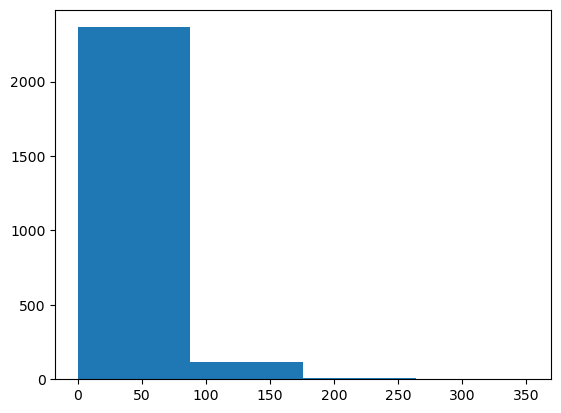

In [97]:
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen,bins=4)
plt.show()

In [98]:
## 정수 인코딩 및 패딩
import numpy as np
# 패딩까지 해주는 함수
def pad_sequences(sequences, max_length, pad_value):  
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] 
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length   
        result.append(padded_sequence)
    return np.asarray(result)  

In [99]:
unk_id = token_to_id["<unk>"]   
train_ids = [[token_to_id.get(token, unk_id) for token in review] for review in train_tokens]  
test_ids = [[token_to_id.get(token, unk_id) for token in review] for review in test_tokens]

max_length = 60
pad_id = token_to_id["<pad>"]   
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[1001 1438  921  293    7  751    5    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[  18  500    1  223 1526  235   33  160    1   33 3822  806 1526    1
   17  500    1  223   35    1 2388   72   30   28    1  500    1  223
  511    1  284  826    1  836  317    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [100]:
train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.category.values, dtype=torch.float32)
test_labels = torch.tensor(test.category.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [101]:
# 문장 분류하는 모델
class SentenceClassifier(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, n_classes ,dropout=0.5, bidirectional=True, model_type="lstm"):
        super().__init__()  # 부모클래스 상속

        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim, padding_idx=0)

        # rnn모델 일 경우
        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )
        # lstm모델 일 경우
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )

        # bidirectional은 양방향성을 의미하는 파라미터
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, n_classes)   # 양방향일때 타임스탭에서 양방향의 정보(순방향,역방향)의 출력들을 결합하여 분류기에 전달
        else:
            self.classifier = nn.Linear(hidden_dim, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings) 
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [102]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

In [103]:
## 손실 함수와 최적화 함수 정의
LR = 0.001
n_vocab = len(token_to_id)   # 단어사전의 크기
hidden_dim = 128     # 은닉 사태의 크기
embedding_dim = 128   #임베딩 벡터의 차원 128차원으로 사용
n_layers = 2     # 2층
n_classes = 1 # 2진 분류라 

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers, n_classes=n_classes).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)   
optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [104]:
# 모델 학습하는 함수
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}')

In [105]:
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    all_labels = []
    all_predictions = []

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())

        # 예측 값과 실제 값 저장
        yhat = (torch.sigmoid(logits) > 0.5).cpu().numpy()
        all_predictions.extend(yhat)
        all_labels.extend(labels.cpu().numpy())

    val_loss = np.mean(losses)

    # F1 Score 계산 (binary=True로 설정하여 2진 분류 F1 점수 계산)
    val_f1_score = f1_score(all_labels, all_predictions)

    print(f"Val Loss : {val_loss}, Val F1 Score : {val_f1_score}")
    return val_loss

In [106]:
epochs = 100
interval = 500   

for epoch in range(epochs):
    print(f'epoch : {epoch}')
    train(classifier, train_loader, criterion, optimizer, device, interval)
    val_loss = test(classifier, test_loader, criterion, device)
    scheduler.step(val_loss)

epoch : 0
Train Loss 0 : 0.701035737991333
Val Loss : 0.5317776964770423, Val F1 Score : 0.8853118712273642
epoch : 1
Train Loss 0 : 0.7957736253738403
Val Loss : 0.5397302152382003, Val F1 Score : 0.8853118712273642
epoch : 2
Train Loss 0 : 0.7952775955200195
Val Loss : 0.5351609720124139, Val F1 Score : 0.8762677484787018
epoch : 3
Train Loss 0 : 0.5112828016281128
Val Loss : 0.5038587037059996, Val F1 Score : 0.8853118712273642
epoch : 4
Train Loss 0 : 0.467223584651947
Val Loss : 0.4415547963645723, Val F1 Score : 0.902654867256637
epoch : 5
Train Loss 0 : 0.2974957823753357
Val Loss : 0.5600279238488939, Val F1 Score : 0.6647058823529413
epoch : 6
Train Loss 0 : 0.3402537703514099
Val Loss : 0.44361309458812076, Val F1 Score : 0.8878504672897196
epoch : 7
Train Loss 0 : 0.29404088854789734
Val Loss : 0.510627005663183, Val F1 Score : 0.9151785714285713
epoch : 8
Train Loss 0 : 0.13577531278133392
Val Loss : 0.5306243970990181, Val F1 Score : 0.9210526315789475
epoch : 9
Train Loss

In [107]:
import seaborn as sns

# 모델 테스트하고 혼동 행렬을 시각화하는 함수
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    
    # 실제 레이블과 예측 값을 저장할 리스트
    all_labels = []
    all_predictions = []

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())

        # 예측 값과 실제 값을 리스트에 추가
        yhat = torch.sigmoid(logits) > 0.5  
        all_labels.extend(labels.cpu().tolist())  # 실제 레이블
        all_predictions.extend(yhat.cpu().tolist())  # 예측 값

        corrects.extend(torch.eq(yhat, labels).cpu().tolist())

    val_loss = np.mean(losses)
    val_accuracy = np.mean(corrects)

    print(f"Val Loss : {val_loss}, Val Accuracy : {val_accuracy}")

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_predictions)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return val_loss

Val Loss : 0.5825968724158075, Val Accuracy : 0.851985559566787


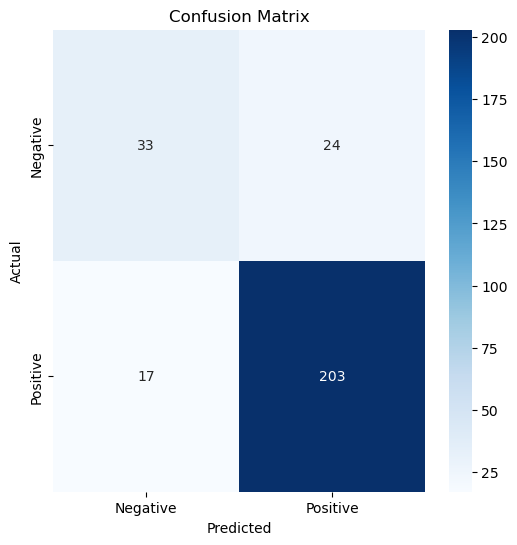

In [108]:
val_loss = test(classifier, test_loader, criterion, device)

In [109]:
torch.save(classifier, f'best_model.pth')

In [110]:
import pickle
# 단어 사전 저장
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.
